In [1]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, MSELoss
from torch.optim import Adam, SGD

from skimage.transform import resize

In [2]:
import random

my_seed = 3
random.seed(my_seed)
torch.manual_seed(my_seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(my_seed)

In [3]:
# loading dataset
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

sample_submission = pd.read_csv('sample_submission.csv')

train.head()

track     views country     score
0  normalize_5s_intro_thc1MtNagC8.wav  38319601     NaN  0.676471
1  normalize_5s_intro_Wo2qUD1g7xM.wav  71940972      VN  0.666667
2  normalize_5s_intro_3ObVN3QQiZ8.wav  28548855      FR  0.447368
3  normalize_5s_intro_S-zQJFRX5Fg.wav    310197     NaN  0.876712
4  normalize_5s_intro_SyZOAgXiPMw.wav   1283578     NaN  0.325000

In [4]:
# loading training images
train_img = []
for img_name in tqdm(train['track']):
    # defining the image path
    image_path = './img/' + str(img_name) + '.jpg'
    # reading the image
    img = imread(image_path)
    img = resize(img, (28, 28))
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # normalizing the pixel values
    #img /= 255.0
    # appending the image into the list
    train_img.append(img)

# converting the list to numpy array
train_x = np.array(train_img)
# defining the target
train_y = train['score'].values

#print(train_x)
#print(train_y)

train_x.shape

100%|███████████████████████████████████████████████████████████████████████████████| 220/220 [00:02<00:00, 109.68it/s]


(220, 28, 28, 3)

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x1fbeab7b848>)

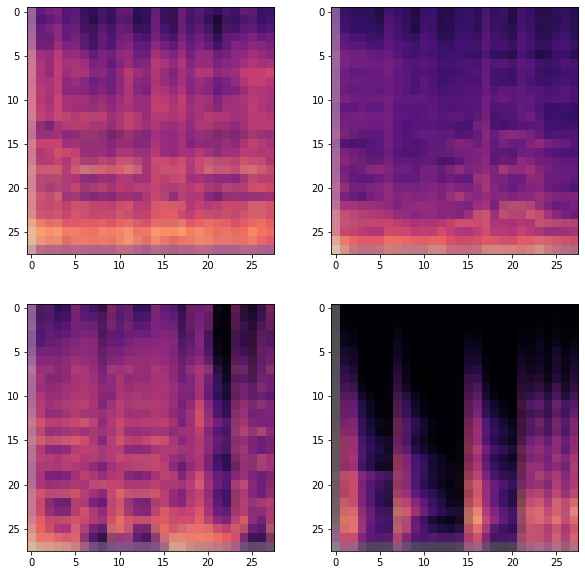

In [5]:
# visualizing images
i = 0
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(train_x[i], cmap='gray')
plt.subplot(222), plt.imshow(train_x[i+25], cmap='gray')
plt.subplot(223), plt.imshow(train_x[i+50], cmap='gray')
plt.subplot(224), plt.imshow(train_x[i+75], cmap='gray')

In [6]:
# create validation set
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, random_state=my_seed, test_size = 0.05)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

#print(train_y)
#print(val_y)

(((209, 28, 28, 3), (209,)), ((11, 28, 28, 3), (11,)))

In [7]:
# converting training images into torch format
train_x = train_x.reshape(209, 3, 28, 28)
train_x  = torch.from_numpy(train_x)

# converting the target into torch format
train_y = train_y.astype(float);
train_y = torch.from_numpy(train_y)

# shape of training data
train_x.shape, train_y.shape

(torch.Size([209, 3, 28, 28]), torch.Size([209]))

In [8]:
# converting validation images into torch format
val_x = val_x.reshape(11, 3, 28, 28)
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
val_y = val_y.astype(float);
val_y = torch.from_numpy(val_y)

# shape of validation data
val_x.shape, val_y.shape

(torch.Size([11, 3, 28, 28]), torch.Size([11]))

In [9]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(3, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(4 * 7 * 7, 1)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        #print(x)
        x = self.linear_layers(x)
        return x

In [10]:
# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.05)
# defining the loss function
criterion = MSELoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=196, out_features=1, bias=True)
  )
)


In [11]:
def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    
    #print('!!!!!')
    #print(y_train)
    #print('?????')
    #print(train_y)
    
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train)
    output_val = model(x_val)

    # computing the training and validation loss
    output_train=output_train.squeeze(-1)
    output_val=output_val.squeeze(-1)
    loss_train = criterion(output_train, y_train.float())
    loss_val = criterion(output_val, y_val.float())
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    # if epoch%2 == 0:
    # printing the validation loss
    print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)

In [12]:
# defining the number of epochs
n_epochs = 300
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    train(epoch)

Epoch :  1 	 loss : tensor(2.1088, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch :  2 	 loss : tensor(26.4701, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch :  3 	 loss : tensor(2.4956, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch :  4 	 loss : tensor(0.7028, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch :  5 	 loss : tensor(4.4031, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch :  6 	 loss : tensor(5.4678, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch :  7 	 loss : tensor(3.5476, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch :  8 	 loss : tensor(1.9914, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch :  9 	 loss : tensor(0.8110, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch :  10 	 loss : tensor(0.1783, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch :  11 	 loss : tensor(0.1181, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch :  12 	 loss : tensor(0.3588, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch :  13 	 loss : tensor(0.5297, device='cuda

Epoch :  118 	 loss : tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch :  119 	 loss : tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch :  120 	 loss : tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch :  121 	 loss : tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch :  122 	 loss : tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch :  123 	 loss : tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch :  124 	 loss : tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch :  125 	 loss : tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch :  126 	 loss : tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch :  127 	 loss : tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch :  128 	 loss : tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch :  129 	 loss : tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch :  130 	 loss : tensor

Epoch :  238 	 loss : tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch :  239 	 loss : tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch :  240 	 loss : tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch :  241 	 loss : tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch :  242 	 loss : tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch :  243 	 loss : tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch :  244 	 loss : tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch :  245 	 loss : tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch :  246 	 loss : tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch :  247 	 loss : tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch :  248 	 loss : tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch :  249 	 loss : tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch :  250 	 loss : tensor

In [13]:
# prediction for training set
with torch.no_grad():
    output = model(train_x.cuda())
 
softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

#print(train_y)
#print(predictions)

# accuracy on training set
#accuracy_score(train_y, predictions)

In [14]:
# prediction for validation set
with torch.no_grad():
    output = model(val_x.cuda())

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on validation set
#accuracy_score(val_y, predictions)

In [15]:
# loading test images
test_img = []
for img_name in tqdm(test['track']):
    # defining the image path
    image_path = './img/' + str(img_name) + '.jpg'
    # reading the image
    img = imread(image_path)
    # normalizing the pixel values
    #img /= 255.0
    img = resize(img, (28, 28))
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    test_img.append(img)

# converting the list to numpy array
test_x = np.array(test_img)
test_x.shape

100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 105.89it/s]


(15, 28, 28, 3)

In [16]:
# converting training images into torch format
test_x = test_x.reshape(15, 3, 28, 28)
test_x  = torch.from_numpy(test_x)
test_x.shape

torch.Size([15, 3, 28, 28])

In [17]:
# generating predictions for test set
with torch.no_grad():
    output = model(test_x.cuda())

print(output)

#softmax = torch.exp(output).cpu()
#prob = list(softmax.numpy())
#predictions = np.argmax(prob, axis=1)

tensor([[0.6606],
        [0.7452],
        [0.6744],
        [0.5917],
        [0.6060],
        [0.6276],
        [0.6820],
        [0.6547],
        [0.7484],
        [0.6794],
        [0.6111],
        [0.6921],
        [0.7222],
        [0.6509],
        [0.7010]], device='cuda:0')


In [18]:
# replacing the label with prediction
sample_submission['score'] = output.cpu()
sample_submission.head()

track     score
0  normalize_5s_intro_0EVVKs6DQLo.wav  0.660553
1  normalize_5s_intro_d7to9URtLZ4.wav  0.745191
2  normalize_5s_intro_TzhhbYS9EO4.wav  0.674432
3  normalize_5s_intro_nn5nypm7GG8.wav  0.591678
4  normalize_5s_intro_hed6HkYNA7g.wav  0.606012

In [19]:
# saving the file
sample_submission.to_csv('submission.csv', index=False)

In [20]:
torch.save(model, 'CNN.pth')